# Packages

In [1]:
#basic packages
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
from datetime import datetime


#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# data modelling & results
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.model_selection import train_test_split

#NN
import tensorflow as tf

from tensorflow import keras
from keras.utils.vis_utils import plot_model
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

#feature importance
import shap


# Script

## Error computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
#errors computation

def errors_computation(data):
    
    df=pd.DataFrame()
    #df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    #df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    return df

In [5]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('')

In [6]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    
    x=power_curve['Wind Speed [m/s]']
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [7]:
def control_power_computation (data_test, data_train, power_curve):
    
    results_test=pd.DataFrame()
    results_train=pd.DataFrame()
    
    
    results_test=powercurve_computation(data_test, power_curve)
    results_train=powercurve_computation(data_train, power_curve)

    return results_test, results_train

In [8]:
def compute_results(data_test, data_train, power_curve, plot_error):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    
    if plot_error:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    return print('Showing the results of the modelling: ')

## Data uploading

In [9]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [10]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

## Data selection

In [11]:
def data_selection(X_train, X_test, inputs):
    
    #this function returns the columns of the training and test sets in the inputs list
    
    X_train1 = pd.DataFrame()
    X_test1 = pd.DataFrame()
    
    
    X_train1 = X_train[inputs]
    X_test1 = X_test[inputs]

    
    return X_train1,X_test1

In [12]:
def data_drop(X_train, X_test, list_2drop):
    
    #this function returns the columns of the training and test sets in the inputs list

    X_train1 = X_train.drop(columns=list_2drop)
    X_test1 = X_test.drop(columns=list_2drop)

    
    
    return X_train1,X_test1

## Modelling

### Model building

In [13]:
def build_model (n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8],
                 activation='relu', optimizer='Adam', regularization=None, Leaky=False):
    
    #this function build model is created only for building the NN
    #it will always initialize the weights using the strategy 'He normal' unless activation function 'selu' is selected
    
    
    if activation!='relu':
        Leaky==False
    
    
    #we create a sequential model:
    model=keras.models.Sequential()
    
    #we add the input layer with n_neurons=n_features (shape of X_train)
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    #we add a hidden layer for each n_hidden with ReLU as activation function
    #this code considers the same n_neurons for each hidden layer
    for layer in range(n_hidden):
        
        if regularization=='l2':
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal',
                                            kernel_regularizer=keras.regularizers.l2(0.01)))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal',
                                            kernel_regularizer=keras.regularizers.l2(0.01)))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal',
                                           kernel_regularizer=keras.regularizers.l2(0.01)))  
        elif regularization=='l1':
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal',
                                             kernel_regularizer=keras.regularizers.l1(0.01)))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal',
                                             kernel_regularizer=keras.regularizers.l1(0.01)))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal',
                                            kernel_regularizer=keras.regularizers.l1(0.01))) 
        else:
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal'))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal'))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal'))
        
        if Leaky:
            model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    #dropout only considered in the last layer
    if regularization=='Dropout':
        model.add(keras.layers.Dropout(rate=0.2))
        
    #we add the output layer with one neuron (we only want to predict 1 target)
    model.add(keras.layers.Dense(1))
    
    #we choose our optimizer and build it:
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    elif optimizer=='Momentum':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    elif optimizer=='Nesterov':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate, rho=0.9)
    elif optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer=='Nadam':
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    #we compile our model with the selected optimizer and set the objective function loss='mse'
    model.compile(loss='mse', optimizer=optimizer)
    
    return model
    

In [14]:
def build_model_old (n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8],
                 activation='relu', optimizer='Adam', regularization=None, Leaky=False):
    
    #this function build model is created only for building the NN
    #it will always initialize the weights using the strategy 'He normal' unless activation function 'selu' is selected
    
    
    if activation!='relu':
        Leaky==False
    
    
    #we create a sequential model:
    model=keras.models.Sequential()
    
    #we add the input layer with n_neurons=n_features (shape of X_train)
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    #we add a hidden layer for each n_hidden with ReLU as activation function
    #this code considers the same n_neurons for each hidden layer
    for layer in range(n_hidden):
        if activation=='relu':
            model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal'))
        elif activation=='elu':
            model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal'))
        elif activation=='selu':
            model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal'))
        if Leaky:
            model.add(keras.layers.LeakyReLU(alpha=0.2))
            
    if regularization=='Dropout':
        model.add(keras.layers.Dropout(rate=0.2))
        
    #we add the output layer with one neuron (we only want to predict 1 target)
    model.add(keras.layers.Dense(1))
    
    #we choose our optimizer and build it:
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    elif optimizer=='Momentum':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    elif optimizer=='Nesterov':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate, rho=0.9)
    elif optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer=='Nadam':
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    #we compile our model with the selected optimizer and set the objective function loss='mse'
    model.compile(loss='mse', optimizer=optimizer)
    
    return model
    

### Modelling NN

In [15]:
def modelling_NN (X, X_test, y, y_test, power_curve,  parameters, plot_error, plot):
    
    #creating the model
    
    n_hidden=parameters['n_hidden']
    n_neurons=parameters['n_neurons']
    learning_rate=parameters['learning_rate']
    input_shape=X.shape[1:]
    activation=parameters['activation']
    optimizer=parameters['optimizer']
    regularization=parameters['regularization']
    Leaky=parameters['Leaky']
    
    model =build_model(n_hidden, n_neurons, learning_rate, input_shape,
                 activation, optimizer, regularization, Leaky)
 
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    

    if regularization=='Early Stopping':
        model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    else:
        model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid))
    
    
#     if plot:
#         loss_epochs_plot (history)
        
    
    #model predicting
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    y_pred_valid=model.predict(X_valid)
    
    rmse_valid=rmse(y_valid, y_pred_valid)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    print('')
    print('RMSE for validation', rmse_valid)
    print('')
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('NN modelling performed')
    
    return model

In [16]:
def modelling_NN_ES (X, X_test, y, y_test, power_curve,  parameters, plot_error, plot):
    
    #creating the model
    
    n_hidden=parameters['n_hidden']
    n_neurons=parameters['n_neurons']
    learning_rate=parameters['learning_rate']
    input_shape=X.shape[1:]
    activation=parameters['activation']
    optimizer=parameters['optimizer']
    regularization=parameters['regularization']
    Leaky=parameters['Leaky']
    
    model =build_model(n_hidden, n_neurons, learning_rate, input_shape,
                 activation, optimizer, regularization, Leaky)
 
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    

    model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    
#     if plot:
#         loss_epochs_plot (history)
        
    
    #model predicting
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
#     mse_test=model.evaluate(X_test, y_test)
#     rmse_test=np.sqrt(mse_test)
#     print('RMSE for test', rmse_test)
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('NN modelling performed')
    
    return model

### Random Search NN

In [17]:
def RandomSearch_NN(X, X_test, y, y_test, power_curve, param_distribs, plot_error):
    
    #counting the runing time
    start_time = time.time()
    
    
    #creating the model
    input_shape=X.shape[1:]
    param_distribs['input_shape']=input_shape
    keras_reg =keras.wrappers.scikit_learn.KerasRegressor(build_model, verbose=0)
    
    
    #Random Search CV
    rnd_search_cv=RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3)
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    
    regularization=param_distribs['regularization']
    
    if regularization=='Early Stopping':
        rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    else:
        rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid))
    
    
    #model predicting
    
    model=rnd_search_cv.best_estimator_.model
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(rnd_search_cv.best_params_)
    print('Best score :')
    print(rnd_search_cv.best_score_)
    print('')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('RandomSearch_ NN performed')
    
    return model
    

In [18]:
def RandomSearch_NN_ES(X, X_test, y, y_test, power_curve, param_distribs, plot_error):
    
    #counting the runing time
    start_time = time.time()
    
    #creating the model
    input_shape=X.shape[1:]
    param_distribs['input_shape']=input_shape
    keras_reg =keras.wrappers.scikit_learn.KerasRegressor(build_model, verbose=0)
    
    #Random Search CV
    rnd_search_cv=RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3)
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    
    rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    
    #model predicting
    
    model=rnd_search_cv.best_estimator_.model
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(rnd_search_cv.best_params_)
    print('Best score :')
    print(rnd_search_cv.best_score_)
    print('')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('RandomSearch_ NN performed')
    
    return model

### Loss plot

In [19]:
def loss_epochs_plot (history):
    
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.show
    
    return print('Loss vs. epochs plot performed')
    
    

### Model Testing

In [20]:
def model_testing (X_train, X_test, y_train, y_test, power_curve, model, plot_error):

    

    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    plot_model(model, show_shapes=True, show_layer_names=True)
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    
    WS_pred=data_test['WS_pred']
    print('NN results performed')
    
    return WS_pred

### Feature importance

In [21]:
def feature_importance (X_train, X_test, model):
    
    X_t, X_f, y_t, y_f = train_test_split(X_train,y_train, test_size=0.02, random_state=12)
    
    background = X_f.copy()
    
    explainer = shap.KernelExplainer(model.predict,background)
    shap_values = explainer.shap_values(X_test,nsamples=100)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    print('Feature importance through SHAP values performed')
    

    return shap_values

In [22]:
def transform_shap (shap_values, X_test):

    v=np.array(shap_values)
    d=v.reshape(X_test.shape)
    shap_v=pd.DataFrame(d)
    
    feature_list=X_test.columns
    shap_v.columns=feature_list
    shap_v=shap_v.abs()
    k=pd.DataFrame(shap_v.mean()).reset_index()
    k.columns=['variables','SHAP_abs']
    k.sort_values(by='variables')
    
    return k
    

# Data analysis

## Dataset3- WTG18

In [23]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
X_train= uploading_csv('\Dataset3-New_Site','\X_train18.csv')
X_test= uploading_csv('\Dataset3-New_Site','\X_test18.csv')
y_train= uploading_csv('\Dataset3-New_Site','\y_train18.csv')
y_test= uploading_csv('\Dataset3-New_Site','\y_test18.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [24]:
y_test.keys()

Index(['Target'], dtype='object')

In [25]:
X_test.head()

,WS1,WS3,WS4,WSHor,WDHor,WSVer,WDVer,T1,RH1,T2,...,AD2,Rain,WD1,WD3,WD4,TI,WSH,WD_bin,tod,WVeer
0,0.452444,0.347761,0.202223,0.454517,0.184304,0.680389,0.517188,0.286739,0.603215,0.160345,...,0.789553,0.643465,0.177710,0.343535,0.330779,0.044303,0.800919,0.153846,0.230769,0.610193
1,0.042582,0.142939,0.071787,0.047671,0.445111,0.578917,0.509039,0.452673,0.543242,0.430103,...,0.606720,0.363330,0.441385,0.541391,0.523286,0.014165,0.691417,0.423077,0.048951,0.632766
2,0.002431,0.076393,0.113539,0.005122,0.907204,0.424257,0.303996,0.769867,0.111697,0.769392,...,0.254355,0.257218,0.908858,0.898883,0.902435,0.130473,0.490261,0.923077,0.874126,0.512707
3,0.039519,0.104726,0.076846,0.047924,0.362332,0.586612,0.531281,0.204521,0.915944,0.223248,...,0.694487,0.903226,0.360666,0.480799,0.454734,0.187784,0.668834,0.346154,0.000000,0.666537
4,0.304817,0.368122,0.411495,0.308579,0.432230,0.626046,0.507254,0.602922,0.647608,0.641780,...,0.327677,0.000000,0.428703,0.532343,0.527155,0.292199,0.348341,0.423077,0.958042,0.576159


In [26]:
PC= uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

### RandomSearch

In [27]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam', 'RMSProp'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [28]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [-0.28162809 -2.31641841 -0.22103334 -0.2437923  -0.24043911 -0.28493093
 -0.27551968 -0.28334983         nan -0.30713005 -2.10673717 -0.25823838
 -0.56209338 -0.26626723 -0.25863049 -0.27755742 -0.31576704 -0.23353337
 -0.22374796 -0.24266904]



Best parameters :
{'regularization': None, 'optimizer': 'RMSProp', 'n_neurons': 60, 'n_hidden': 3, 'learning_rate': 0.01, 'input_shape': 24, 'activation': 'relu', 'Leaky': False}
Best score :
-0.22103334466616312

--- 24.763838251431782 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.761 m/s as root mean
Wind MAE:  0.657 m/s in avg
Wind MAPE:  8.411 %
Power RMSE:  429.615 kW as root mean
Power MAE:  337.373 kW in avg
Power MAPE:  21.073 %

Modelling errors for test set:
Wind RMSE:  0.792 m/s as root mean
Wind MAE:  0.667 m/s in avg
Wind MAPE:  8.51 %
Power RMSE:  449.623 kW as root mean
Power MAE:  343.845 kW in avg
Power MAPE:  19.27 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [35]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [36]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [ -0.33635923  -0.24475749  -0.25788202  -0.27939104  -0.24706641
  -0.2708785  -56.77045186  -0.30852381  -0.31891754  -0.31994725
  -0.29888881  -0.26991477  -0.24741414  -0.31562376  -0.30552221
  -0.70065536  -0.2621788           nan  -0.25593152  -0.2879117 ]



Best parameters :
{'regularization': None, 'optimizer': 'Nesterov', 'n_neurons': 20, 'n_hidden': 1, 'learning_rate': 0.01, 'input_shape': 24, 'activation': 'relu', 'Leaky': False}
Best score :
-0.24475749333699545

--- 25.240467631816863 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.517 m/s as root mean
Wind MAE:  0.396 m/s in avg
Wind MAPE:  5.29 %
Power RMSE:  299.055 kW as root mean
Power MAE:  203.149 kW in avg
Power MAPE:  19.243 %

Modelling errors for test set:
Wind RMSE:  0.538 m/s as root mean
Wind MAE:  0.41 m/s in avg
Wind MAPE:  5.395 %
Power RMSE:  306.293 kW as root mean
Power MAE:  206.963 kW in avg
Power MAPE:  13.847 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [37]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [38]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20


Best parameters :
{'regularization': 'Early Stopping', 'optimizer': 'Adam', 'n_neurons': 30, 'n_hidden': 3, 'learning_rate': 0.003, 'input_shape': 24, 'activation': 'elu', 'Leaky': False}
Best score :
-0.22901726265748343

--- 21.87839259703954 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.439 m/s as root mean
Wind MAE:  0.331 m/s in avg
Wind MAPE:  4.386 %
Power RMSE:  254.406 kW as root mean
Power MAE:  169.293 kW in avg
Power MAPE:  15.183 %

Modelling errors for test set:
Wind RMSE:  0.472 m/s as root mean
Wind MAE:  0.351 m/s in avg
Wind MAPE:  4.632 %
Power RMSE:  273.559 kW as root mean
Power MAE:  178.541 kW in avg
Power MAPE:  11.677 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [46]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [47]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
131/131 [==============================] - 1s 5ms/step - loss: 4.9545 - val_loss: 0.5687
Epoch 2/100
131/131 [==============================] - 1s 4ms/step - loss: 0.4291 - val_loss: 0.4056
Epoch 3/100
131/131 [==============================] - 1s 4ms/step - loss: 0.3505 - val_loss: 0.3567
Epoch 4/100
131/131 [==============================] - 1s 5ms/step - loss: 0.3121 - val_loss: 0.2980
Epoch 5/100
131/131 [==============================] - 0s 4ms/step - loss: 0.2833 - val_loss: 0.2892
Epoch 6/100
131/131 [==============================] - 0s 3ms/step - loss: 0.2800 - val_loss: 0.2935
Epoch 7/100
131/131 [==============================] - 0s 3ms/step - loss: 0.2750 - val_loss: 0.4693
Epoch 8/100
131/131 [==============================] - 0s 3ms/step - loss: 0.2722 - val_loss: 0.3048
Epoch 9/100
131/131 [==============================] - 0s 3ms/step - loss: 0.2455 - val_loss: 0.2307
Epoch 10/100
131/131 [==============================] - 0s 3ms/step - loss: 0.2482 - val_lo

In [49]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [50]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
131/131 [==============================] - 1s 6ms/step - loss: 7.8154 - val_loss: 0.5243
Epoch 2/100
131/131 [==============================] - 0s 3ms/step - loss: 0.4527 - val_loss: 0.3811
Epoch 3/100
131/131 [==============================] - 0s 4ms/step - loss: 0.3754 - val_loss: 0.3354
Epoch 4/100
131/131 [==============================] - 0s 2ms/step - loss: 0.3476 - val_loss: 0.3346
Epoch 5/100
131/131 [==============================] - 0s 4ms/step - loss: 0.3253 - val_loss: 0.3045
Epoch 6/100
131/131 [==============================] - 0s 4ms/step - loss: 0.3078 - val_loss: 0.3329
Epoch 7/100
131/131 [==============================] - 1s 7ms/step - loss: 0.3064 - val_loss: 0.3377
Epoch 8/100
131/131 [==============================] - 1s 4ms/step - loss: 0.3024 - val_loss: 0.2718
Epoch 9/100
131/131 [==============================] - 1s 5ms/step - loss: 0.2803 - val_loss: 0.3535
Epoch 10/100
131/131 [==============================] - 0s 4ms/step - loss: 0.2746 - val_lo

In [43]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'selu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [44]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
131/131 [==============================] - 1s 5ms/step - loss: 7.3927 - val_loss: 0.5057
Epoch 2/100
131/131 [==============================] - 0s 3ms/step - loss: 0.4286 - val_loss: 0.3421
Epoch 3/100
131/131 [==============================] - 0s 3ms/step - loss: 0.3686 - val_loss: 0.3087
Epoch 4/100
131/131 [==============================] - 0s 2ms/step - loss: 0.3428 - val_loss: 0.3018
Epoch 5/100
131/131 [==============================] - 0s 3ms/step - loss: 0.3196 - val_loss: 0.2774
Epoch 6/100
131/131 [==============================] - 0s 2ms/step - loss: 0.3022 - val_loss: 0.2716
Epoch 7/100
131/131 [==============================] - 0s 2ms/step - loss: 0.2944 - val_loss: 0.2687
Epoch 8/100
131/131 [==============================] - 0s 4ms/step - loss: 0.2932 - val_loss: 0.2942
Epoch 9/100
131/131 [==============================] - 1s 5ms/step - loss: 0.2784 - val_loss: 0.2891
Epoch 10/100
131/131 [==============================] - 0s 4ms/step - loss: 0.2764 - val_lo

In [39]:
parameters={
    'n_hidden':3,
    'n_neurons': 30,
    'learning_rate':0.003,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [40]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
131/131 [==============================] - 1s 11ms/step - loss: 5.9258 - val_loss: 0.5395
Epoch 2/100
131/131 [==============================] - 0s 2ms/step - loss: 0.4701 - val_loss: 0.4059
Epoch 3/100
131/131 [==============================] - 0s 2ms/step - loss: 0.3965 - val_loss: 0.3218
Epoch 4/100
131/131 [==============================] - 0s 3ms/step - loss: 0.3492 - val_loss: 0.3010
Epoch 5/100
131/131 [==============================] - 0s 2ms/step - loss: 0.3237 - val_loss: 0.2904
Epoch 6/100
131/131 [==============================] - 0s 2ms/step - loss: 0.3106 - val_loss: 0.2919
Epoch 7/100
131/131 [==============================] - 0s 2ms/step - loss: 0.3047 - val_loss: 0.3316
Epoch 8/100
131/131 [==============================] - 0s 3ms/step - loss: 0.2851 - val_loss: 0.2684
Epoch 9/100
131/131 [==============================] - 0s 1ms/step - loss: 0.3017 - val_loss: 0.2874
Epoch 10/100
131/131 [==============================] - 0s 2ms/step - loss: 0.2927 - val_l

### Model saving

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'selu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

MAPE power: 11.723 %

In [34]:
model.save('WTG18_ANN1.h5')

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'selu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

MAPE power: 11.349%

In [45]:
model.save('WTG18_ANN2.h5')

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

MAPE power: 11.016%

In [48]:
model.save('WTG18_ANN3.h5')

### Model testing

In [27]:
model=keras.models.load_model('WTG18_ANN3.h5')

In [28]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.386 m/s as root mean
Wind MAE:  0.289 m/s in avg
Wind MAPE:  3.854 %
Power RMSE:  227.309 kW as root mean
Power MAE:  150.04 kW in avg
Power MAPE:  13.567 %

Modelling errors for test set:
Wind RMSE:  0.438 m/s as root mean
Wind MAE:  0.325 m/s in avg
Wind MAPE:  4.314 %
Power RMSE:  255.622 kW as root mean
Power MAE:  167.087 kW in avg
Power MAPE:  11.016 %

Showing the results of the modelling: 
NN results performed


In [29]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','ANN_WTG18.csv')

file ANN_WTG18.csv saved in \Results_ folder


### Feature importance

Using 105 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2231 [00:00<?, ?it/s]

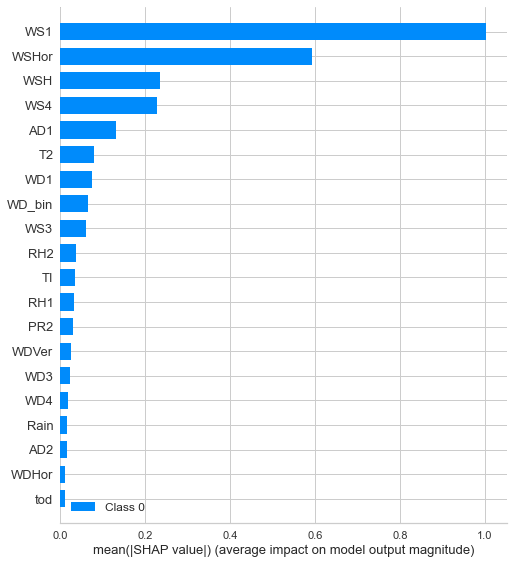

Feature importance through SHAP values performed


In [66]:
shap_values=feature_importance (X_train, X_test, model)

In [67]:
k=transform_shap (shap_values, X_test)

In [68]:
X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [69]:
k

,variables,SHAP_abs
0,WS1,1.002406
1,WS3,0.059724
2,WS4,0.228772
3,WSHor,0.593045
4,WDHor,0.010074
5,WSVer,0.006019
6,WDVer,0.023776
7,T1,0.009568
8,RH1,0.031315
9,T2,0.079024


## Dataset3- WTG20

In [30]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset3-New_Site','\X_train20.csv')
X_test= uploading_csv('\Dataset3-New_Site','\X_test20.csv')
y_train= uploading_csv('\Dataset3-New_Site','\y_train20.csv')
y_test= uploading_csv('\Dataset3-New_Site','\y_test20.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [31]:
y_test.keys()

Index(['Target'], dtype='object')

In [32]:
PC= uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

### Random Search

In [54]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [55]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [ -0.23451791  -0.31686033 -18.29564063  -8.82532199  -9.66797177
  -1.20539242  -0.25203056  -4.76907174  -0.24459523  -0.20385947
  -0.210991    -0.19595151  -0.26079905          nan  -0.2019423
  -0.2298398   -0.21434557  -0.20442386  -0.27653538  -0.24854774]



Best parameters :
{'regularization': 'Early Stopping', 'optimizer': 'Momentum', 'n_neurons': 90, 'n_hidden': 3, 'learning_rate': 0.003, 'input_shape': 24, 'activation': 'elu', 'Leaky': False}
Best score :
-0.1959515114625295

--- 14.987640595436096 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.414 m/s as root mean
Wind MAE:  0.31 m/s in avg
Wind MAPE:  4.154 %
Power RMSE:  257.914 kW as root mean
Power MAE:  174.309 kW in avg
Power MAPE:  11.014 %

Modelling errors for test set:
Wind RMSE:  0.424 m/s as root mean
Wind MAE:  0.315 m/s in avg
Wind MAPE:  4.213 %
Power RMSE:  266.874 kW as root mean
Power MAE:  176.217 kW in avg
Power MAPE:  11.086 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [56]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [57]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20


Best parameters :
{'regularization': 'Early Stopping', 'optimizer': 'Nesterov', 'n_neurons': 40, 'n_hidden': 1, 'learning_rate': 0.01, 'input_shape': 24, 'activation': 'relu', 'Leaky': False}
Best score :
-0.18890997767448425

--- 15.593900048732758 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.468 m/s as root mean
Wind MAE:  0.365 m/s in avg
Wind MAPE:  4.917 %
Power RMSE:  292.336 kW as root mean
Power MAE:  204.671 kW in avg
Power MAPE:  13.158 %

Modelling errors for test set:
Wind RMSE:  0.477 m/s as root mean
Wind MAE:  0.37 m/s in avg
Wind MAPE:  4.955 %
Power RMSE:  297.591 kW as root mean
Power MAE:  206.06 kW in avg
Power MAPE:  13.108 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [65]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [66]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [-0.70918836 -0.21971244 -0.51799845 -0.20276275 -0.26355502 -0.82164464
 -0.22508243 -0.30415701 -0.2987563  -0.1947716          nan -3.41635327
 -0.23954858 -0.2338862  -4.76900228         nan -0.28551358 -0.25895362
 -0.64015321 -0.36292622]



Best parameters :
{'regularization': None, 'optimizer': 'Momentum', 'n_neurons': 90, 'n_hidden': 2, 'learning_rate': 0.003, 'input_shape': 24, 'activation': 'selu', 'Leaky': False}
Best score :
-0.19477159778277078

--- 15.70096283753713 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.417 m/s as root mean
Wind MAE:  0.314 m/s in avg
Wind MAPE:  4.293 %
Power RMSE:  253.676 kW as root mean
Power MAE:  174.297 kW in avg
Power MAPE:  11.681 %

Modelling errors for test set:
Wind RMSE:  0.424 m/s as root mean
Wind MAE:  0.318 m/s in avg
Wind MAPE:  4.312 %
Power RMSE:  259.612 kW as root mean
Power MAE:  175.708 kW in avg
Power MAPE:  11.619 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [58]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [59]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
93/93 [==============================] - 1s 7ms/step - loss: 8.3702 - val_loss: 0.9333
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 0.5058 - val_loss: 0.3612
Epoch 3/100
93/93 [==============================] - 0s 2ms/step - loss: 0.3380 - val_loss: 0.3169
Epoch 4/100
93/93 [==============================] - 0s 3ms/step - loss: 0.2979 - val_loss: 0.2852
Epoch 5/100
93/93 [==============================] - 0s 5ms/step - loss: 0.2886 - val_loss: 0.2668
Epoch 6/100
93/93 [==============================] - 0s 5ms/step - loss: 0.2717 - val_loss: 0.2585
Epoch 7/100
93/93 [==============================] - 0s 3ms/step - loss: 0.2694 - val_loss: 0.2556
Epoch 8/100
93/93 [==============================] - 1s 6ms/step - loss: 0.2547 - val_loss: 0.2492
Epoch 9/100
93/93 [==============================] - 0s 5ms/step - loss: 0.2540 - val_loss: 0.2299
Epoch 10/100
93/93 [==============================] - 0s 5ms/step - loss: 0.2399 - val_loss: 0.2283
Epoch 11/

93/93 [==============================] - ETA: 0s - loss: 0.148 - 0s 3ms/step - loss: 0.1485 - val_loss: 0.1580
Epoch 84/100
93/93 [==============================] - 0s 4ms/step - loss: 0.1489 - val_loss: 0.1532
Epoch 85/100
93/93 [==============================] - 0s 3ms/step - loss: 0.1451 - val_loss: 0.1560
Epoch 86/100
93/93 [==============================] - 0s 3ms/step - loss: 0.1570 - val_loss: 0.1576
Epoch 87/100
93/93 [==============================] - 0s 2ms/step - loss: 0.1580 - val_loss: 0.1480
Epoch 88/100
93/93 [==============================] - 0s 3ms/step - loss: 0.1482 - val_loss: 0.1522
Epoch 89/100
93/93 [==============================] - 0s 2ms/step - loss: 0.1544 - val_loss: 0.1543
Epoch 90/100
93/93 [==============================] - 0s 2ms/step - loss: 0.1449 - val_loss: 0.1856
Epoch 91/100
93/93 [==============================] - 0s 2ms/step - loss: 0.1541 - val_loss: 0.1600
Epoch 92/100
93/93 [==============================] - 0s 2ms/step - loss: 0.1498 - val_lo

In [61]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [62]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
93/93 [==============================] - 1s 10ms/step - loss: 7.2412 - val_loss: 0.4890
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 0.3653 - val_loss: 0.3331
Epoch 3/100
93/93 [==============================] - 0s 4ms/step - loss: 0.3207 - val_loss: 0.2895
Epoch 4/100
93/93 [==============================] - 0s 5ms/step - loss: 0.3025 - val_loss: 0.3034
Epoch 5/100
93/93 [==============================] - 0s 5ms/step - loss: 0.2822 - val_loss: 0.2660
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 0.2602 - val_loss: 0.2674
Epoch 7/100
93/93 [==============================] - 0s 4ms/step - loss: 0.2515 - val_loss: 0.2369
Epoch 8/100
93/93 [==============================] - 0s 5ms/step - loss: 0.2444 - val_loss: 0.2616
Epoch 9/100
93/93 [==============================] - 0s 4ms/step - loss: 0.2302 - val_loss: 0.2244
Epoch 10/100
93/93 [==============================] - 0s 3ms/step - loss: 0.2237 - val_loss: 0.2208
Epoch 11

### Model saving

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

MAPE power: 9.429%

In [60]:
model.save('WTG20_ANN1.h5')

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

MAPE power: 9.723%

In [63]:
model.save('WTG20_ANN2.h5')

### Model testing

In [75]:
#computing

In [33]:
model=keras.models.load_model('WTG20_ANN1.h5')

In [34]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.366 m/s as root mean
Wind MAE:  0.27 m/s in avg
Wind MAPE:  3.519 %
Power RMSE:  233.809 kW as root mean
Power MAE:  154.766 kW in avg
Power MAPE:  8.815 %

Modelling errors for test set:
Wind RMSE:  0.398 m/s as root mean
Wind MAE:  0.291 m/s in avg
Wind MAPE:  3.79 %
Power RMSE:  247.327 kW as root mean
Power MAE:  162.78 kW in avg
Power MAPE:  9.429 %

Showing the results of the modelling: 
NN results performed


In [35]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','ANN_WTG20.csv')

file ANN_WTG20.csv saved in \Results_ folder


### Feature importance

  0%|          | 0/1586 [00:00<?, ?it/s]

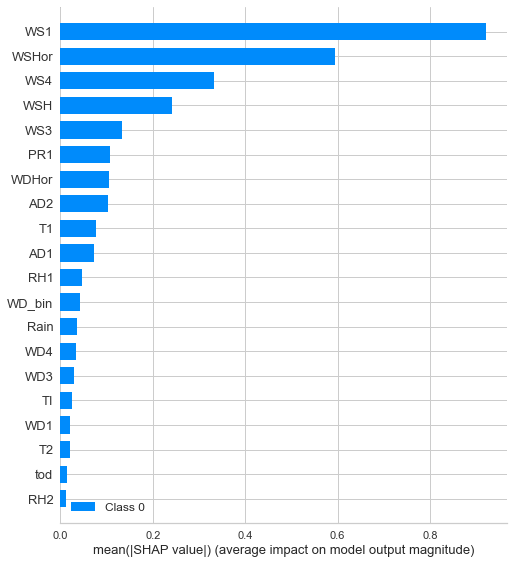

Feature importance through SHAP values performed


In [79]:
shap_values=feature_importance (X_train, X_test, model)

In [80]:
k=transform_shap (shap_values, X_test)

In [81]:
k

,variables,SHAP_abs
0,WS1,0.920147
1,WS3,0.133266
2,WS4,0.332131
3,WSHor,0.594574
4,WDHor,0.104770
5,WSVer,0.010211
6,WDVer,0.007050
7,T1,0.076187
8,RH1,0.046897
9,T2,0.020094


## Dataset3- WTG43

In [36]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset3-New_Site','\X_train43.csv')
X_test= uploading_csv('\Dataset3-New_Site','\X_test43.csv')
y_train= uploading_csv('\Dataset3-New_Site','\y_train43.csv')
y_test= uploading_csv('\Dataset3-New_Site','\y_test43.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [37]:
y_test.keys()

Index(['Target'], dtype='object')

In [38]:
PC= uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

### Random Search

In [27]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [28]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [ -0.36723889 -11.68513997  -0.50415119  -0.37086029  -0.30759893
  -0.31647501  -0.63337992  -0.31210221 -12.65431945  -5.7615143
  -1.03436295  -0.28930667  -4.61528929  -0.3417361   -0.34600702
          nan  -0.40364202  -0.28754005  -0.32675204  -0.36851533]



Best parameters :
{'regularization': None, 'optimizer': 'Momentum', 'n_neurons': 90, 'n_hidden': 1, 'learning_rate': 0.01, 'input_shape': 24, 'activation': 'relu', 'Leaky': False}
Best score :
-0.2875400483608246

--- 27.110408918062845 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.503 m/s as root mean
Wind MAE:  0.379 m/s in avg
Wind MAPE:  4.701 %
Power RMSE:  283.235 kW as root mean
Power MAE:  172.766 kW in avg
Power MAPE:  11.208 %

Modelling errors for test set:
Wind RMSE:  0.524 m/s as root mean
Wind MAE:  0.395 m/s in avg
Wind MAPE:  4.831 %
Power RMSE:  292.719 kW as root mean
Power MAE:  173.225 kW in avg
Power MAPE:  11.25 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [29]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [30]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [-0.3477762  -0.46931786 -0.36191315 -0.3403027  -0.32328708 -0.37966281
 -0.32283702 -3.11807532 -0.31583616 -0.35440189 -0.36590504 -0.31171035
 -0.35772211 -0.30630846 -0.32278278 -0.37699768 -0.33949298         nan
 -0.33789137 -0.96155095]



Best parameters :
{'regularization': None, 'optimizer': 'Adam', 'n_neurons': 50, 'n_hidden': 1, 'learning_rate': 0.003, 'input_shape': 24, 'activation': 'relu', 'Leaky': True}
Best score :
-0.30630845824877423

--- 29.434219217300416 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.504 m/s as root mean
Wind MAE:  0.378 m/s in avg
Wind MAPE:  4.643 %
Power RMSE:  280.716 kW as root mean
Power MAE:  171.124 kW in avg
Power MAPE:  10.893 %

Modelling errors for test set:
Wind RMSE:  0.519 m/s as root mean
Wind MAE:  0.388 m/s in avg
Wind MAPE:  4.74 %
Power RMSE:  287.202 kW as root mean
Power MAE:  170.288 kW in avg
Power MAPE:  10.977 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [42]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [43]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
112/112 [==============================] - 2s 16ms/step - loss: 11.4603 - val_loss: 0.6939
Epoch 2/100
112/112 [==============================] - 1s 8ms/step - loss: 0.5429 - val_loss: 0.4860
Epoch 3/100
112/112 [==============================] - 1s 9ms/step - loss: 0.4351 - val_loss: 0.4319
Epoch 4/100
112/112 [==============================] - 1s 8ms/step - loss: 0.4038 - val_loss: 0.4375
Epoch 5/100
112/112 [==============================] - 1s 8ms/step - loss: 0.3788 - val_loss: 0.4094
Epoch 6/100
112/112 [==============================] - 1s 7ms/step - loss: 0.3646 - val_loss: 0.3709
Epoch 7/100
112/112 [==============================] - 1s 8ms/step - loss: 0.3606 - val_loss: 0.3685
Epoch 8/100
112/112 [==============================] - 1s 7ms/step - loss: 0.3757 - val_loss: 0.4415
Epoch 9/100
112/112 [==============================] - 1s 6ms/step - loss: 0.3405 - val_loss: 0.3513
Epoch 10/100
112/112 [==============================] - 1s 10ms/step - loss: 0.3422 - val

In [33]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [34]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
112/112 [==============================] - 1s 8ms/step - loss: 12.3863 - val_loss: 0.6166
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 0.4730 - val_loss: 0.4704
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 0.4061 - val_loss: 0.4194
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 0.3862 - val_loss: 0.4020
Epoch 5/100
112/112 [==============================] - 0s 4ms/step - loss: 0.3646 - val_loss: 0.3677
Epoch 6/100
112/112 [==============================] - 0s 4ms/step - loss: 0.3545 - val_loss: 0.3534
Epoch 7/100
112/112 [==============================] - 0s 4ms/step - loss: 0.3437 - val_loss: 0.3440
Epoch 8/100
112/112 [==============================] - 1s 5ms/step - loss: 0.3428 - val_loss: 0.4263
Epoch 9/100
112/112 [==============================] - 1s 5ms/step - loss: 0.3393 - val_loss: 0.3243
Epoch 10/100
112/112 [==============================] - 1s 5ms/step - loss: 0.3283 - val_l

In [35]:
parameters={
    'n_hidden':1,
    'n_neurons': 50,
    'learning_rate':0.003,
    'activation':'relu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [36]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
112/112 [==============================] - 1s 13ms/step - loss: 15.4368 - val_loss: 2.4230
Epoch 2/100
112/112 [==============================] - 0s 3ms/step - loss: 1.1981 - val_loss: 0.6430
Epoch 3/100
112/112 [==============================] - 0s 3ms/step - loss: 0.5554 - val_loss: 0.5218
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 0.4806 - val_loss: 0.5035
Epoch 5/100
112/112 [==============================] - 0s 3ms/step - loss: 0.4395 - val_loss: 0.4481
Epoch 6/100
112/112 [==============================] - 0s 3ms/step - loss: 0.4128 - val_loss: 0.4232
Epoch 7/100
112/112 [==============================] - 0s 3ms/step - loss: 0.4002 - val_loss: 0.4195
Epoch 8/100
112/112 [==============================] - 0s 4ms/step - loss: 0.3912 - val_loss: 0.4142
Epoch 9/100
112/112 [==============================] - 0s 3ms/step - loss: 0.3845 - val_loss: 0.4165
Epoch 10/100
112/112 [==============================] - 0s 3ms/step - loss: 0.3824 - val_

### Model saving

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

MAPE wind: 9.476%

In [44]:
model.save('WTG43_ANN1.h5')

### Model testing

In [39]:
model=keras.models.load_model('WTG43_ANN1.h5')

In [40]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.432 m/s as root mean
Wind MAE:  0.327 m/s in avg
Wind MAPE:  3.921 %
Power RMSE:  236.508 kW as root mean
Power MAE:  145.661 kW in avg
Power MAPE:  8.567 %

Modelling errors for test set:
Wind RMSE:  0.491 m/s as root mean
Wind MAE:  0.37 m/s in avg
Wind MAPE:  4.408 %
Power RMSE:  267.616 kW as root mean
Power MAE:  161.384 kW in avg
Power MAPE:  9.476 %

Showing the results of the modelling: 
NN results performed


In [41]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','ANN_WTG43.csv')

file ANN_WTG43.csv saved in \Results_ folder


### Feature importance

  0%|          | 0/1918 [00:00<?, ?it/s]

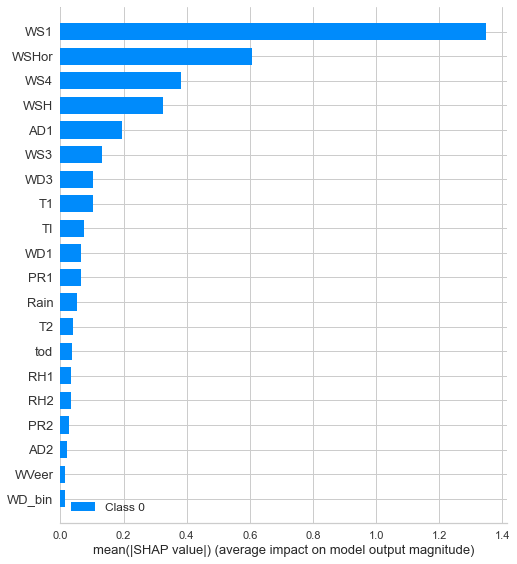

Feature importance through SHAP values performed


In [88]:
shap_values=feature_importance (X_train, X_test, model)

In [89]:
k=transform_shap (shap_values, X_test)

In [90]:
k

,variables,SHAP_abs
0,WS1,1.347295
1,WS3,0.132814
2,WS4,0.380705
3,WSHor,0.605584
4,WDHor,0.009814
5,WSVer,0.013090
6,WDVer,0.005709
7,T1,0.104708
8,RH1,0.034690
9,T2,0.038729


## Dataset3- WTG46

In [42]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset3-New_Site','\X_train46.csv')
X_test= uploading_csv('\Dataset3-New_Site','\X_test46.csv')
y_train= uploading_csv('\Dataset3-New_Site','\y_train46.csv')
y_test= uploading_csv('\Dataset3-New_Site','\y_test46.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [43]:
y_test.keys()

Index(['Target'], dtype='object')

In [44]:
PC= uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

### Random Search

In [51]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [52]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [        nan -0.14991749 -0.14112541 -0.15147516 -0.16234613 -0.13085179
 -0.16194989 -0.16134451 -7.9557333  -0.14604313 -0.16529974 -0.13819598
 -0.61050423 -0.15987088 -0.12899678 -0.39793547 -0.21996407 -0.14488961
 -0.15048811 -0.15192912]



Best parameters :
{'regularization': None, 'optimizer': 'Nadam', 'n_neurons': 70, 'n_hidden': 1, 'learning_rate': 0.005, 'input_shape': 24, 'activation': 'relu', 'Leaky': False}
Best score :
-0.12899678200483322

--- 21.835569846630097 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.341 m/s as root mean
Wind MAE:  0.252 m/s in avg
Wind MAPE:  3.507 %
Power RMSE:  208.634 kW as root mean
Power MAE:  135.901 kW in avg
Power MAPE:  9.713 %

Modelling errors for test set:
Wind RMSE:  0.363 m/s as root mean
Wind MAE:  0.269 m/s in avg
Wind MAPE:  3.755 %
Power RMSE:  218.66 kW as root mean
Power MAE:  144.364 kW in avg
Power MAPE:  10.412 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [54]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [55]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
114/114 [==============================] - 1s 7ms/step - loss: 9.4200 - val_loss: 0.3310
Epoch 2/100
114/114 [==============================] - 1s 6ms/step - loss: 0.2709 - val_loss: 0.2347
Epoch 3/100
114/114 [==============================] - 0s 4ms/step - loss: 0.2224 - val_loss: 0.2071
Epoch 4/100
114/114 [==============================] - 0s 4ms/step - loss: 0.2007 - val_loss: 0.1869
Epoch 5/100
114/114 [==============================] - 0s 4ms/step - loss: 0.1882 - val_loss: 0.1779
Epoch 6/100
114/114 [==============================] - 1s 4ms/step - loss: 0.1704 - val_loss: 0.1779
Epoch 7/100
114/114 [==============================] - 1s 5ms/step - loss: 0.1693 - val_loss: 0.1638
Epoch 8/100
114/114 [==============================] - 1s 5ms/step - loss: 0.1600 - val_loss: 0.1647
Epoch 9/100
114/114 [==============================] - 1s 7ms/step - loss: 0.1572 - val_loss: 0.1502
Epoch 10/100
114/114 [==============================] - 1s 5ms/step - loss: 0.1508 - val_lo

In [59]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

In [60]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
114/114 [==============================] - 1s 11ms/step - loss: 7.8658 - val_loss: 0.3844
Epoch 2/100
114/114 [==============================] - 1s 7ms/step - loss: 0.2918 - val_loss: 0.2242
Epoch 3/100
114/114 [==============================] - 1s 10ms/step - loss: 0.2180 - val_loss: 0.1995
Epoch 4/100
114/114 [==============================] - 1s 9ms/step - loss: 0.1895 - val_loss: 0.1710
Epoch 5/100
114/114 [==============================] - 1s 10ms/step - loss: 0.1775 - val_loss: 0.1964
Epoch 6/100
114/114 [==============================] - 1s 8ms/step - loss: 0.1643 - val_loss: 0.2203
Epoch 7/100
114/114 [==============================] - 1s 10ms/step - loss: 0.1623 - val_loss: 0.1622
Epoch 8/100
114/114 [==============================] - 1s 9ms/step - loss: 0.1559 - val_loss: 0.1549
Epoch 9/100
114/114 [==============================] - 2s 14ms/step - loss: 0.1507 - val_loss: 0.1617
Epoch 10/100
114/114 [==============================] - 2s 14ms/step - loss: 0.1512 - 

### Model saving

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping',
    'Leaky':True
}

MAPE power: 9.8%

In [58]:
model.save('WTG46_ANN1.h5')

### Model testing

In [45]:
model=keras.models.load_model('WTG46_ANN1.h5')

In [46]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.336 m/s as root mean
Wind MAE:  0.247 m/s in avg
Wind MAPE:  3.412 %
Power RMSE:  207.686 kW as root mean
Power MAE:  133.525 kW in avg
Power MAPE:  9.306 %

Modelling errors for test set:
Wind RMSE:  0.358 m/s as root mean
Wind MAE:  0.257 m/s in avg
Wind MAPE:  3.582 %
Power RMSE:  217.147 kW as root mean
Power MAE:  139.206 kW in avg
Power MAPE:  9.803 %

Showing the results of the modelling: 
NN results performed


In [47]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','ANN_WTG46.csv')

file ANN_WTG46.csv saved in \Results_ folder


### Feature importance

In [94]:
#computing

  0%|          | 0/1956 [00:00<?, ?it/s]

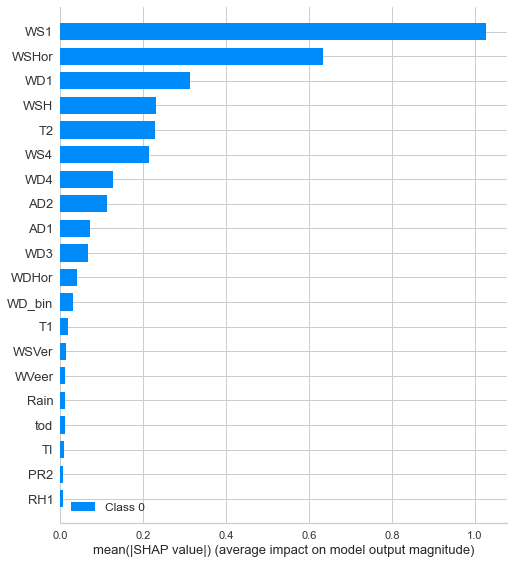

Feature importance through SHAP values performed


In [98]:
shap_values=feature_importance (X_train, X_test, model)

In [99]:
k=transform_shap (shap_values, X_test)

In [100]:
k

,variables,SHAP_abs
0,WS1,1.026710
1,WS3,0.002243
2,WS4,0.213336
3,WSHor,0.633384
4,WDHor,0.041101
5,WSVer,0.014257
6,WDVer,0.003971
7,T1,0.019127
8,RH1,0.007010
9,T2,0.227647
